In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# dicomparser.py
"""Class that parses and returns formatted DICOM RT data."""
# Copyright (c) 2009-2016 Aditya Panchal
# Copyright (c) 2009-2010 Roy Keyes
# This file is part of dicompyler-core, released under a BSD license.
#    See the file license.txt included with this distribution, also
#    available at https://github.com/dicompyler/dicompyler-core/


import logging
import numpy as np
try:
    from pydicom.dicomio import read_file
    from pydicom.dataset import Dataset, validate_file_meta
    from pydicom.pixel_data_handlers.util import pixel_dtype
except ImportError:
    from dicom import read_file
    from dicom.dataset import Dataset
import random
from numbers import Number
from io import BytesIO
from pathlib import Path
from dicompylercore import dvh, util
from dicompylercore.config import pil_available, shapely_available

if pil_available:
    from PIL import Image
if shapely_available:
    from shapely.geometry import Polygon

logger = logging.getLogger('dicompylercore.dicomparser')


class DicomParser:
    """Class to parse DICOM / DICOM RT files."""

    def __init__(self, dataset, memmap_pixel_array=False):
        """Initialize DicomParser from a pydicom Dataset or DICOM file.

        Parameters
        ----------
        dataset : pydicom Dataset or filename
            pydicom dataset object or DICOM file location
        memmap_pixel_array : bool, optional
            Enable pixel array access via memory mapping, by default False

        Raises
        ------
        AttributeError
            Raised if SOPClassUID is not present in the pydicom Dataset
        AttributeError
            Raised if the DICOM file or pydicom Dataset cannot be read
        """
        self.memmap_pixel_array = memmap_pixel_array
        if isinstance(dataset, Dataset):
            self.ds = dataset
        elif isinstance(dataset, (str, BytesIO, Path)):
            try:
                with open(dataset, "rb") as fp:
                    self.ds = read_file(fp, defer_size=100, force=True,
                                        stop_before_pixels=memmap_pixel_array)
                    if memmap_pixel_array:
                        self.offset = fp.tell() + 8
            except Exception:
                # Raise the error for the calling method to handle
                raise
            else:
                # Sometimes DICOM files may not have headers,
                # but they should always have a SOPClassUID
                # to declare what type of file it is.
                # If the file doesn't have a SOPClassUID,
                # then it probably isn't DICOM.
                if "SOPClassUID" not in self.ds:
                    raise AttributeError
        else:
            raise AttributeError

        # Fix dataset file_meta if incorrect
        try:
            validate_file_meta(self.ds.file_meta)
        except ValueError:
            logger.debug('Fixing invalid File Meta for ' +
                         str(self.ds.SOPInstanceUID))
            self.ds.fix_meta_info()

        # Remove the PixelData attribute if it is not set.
        # i.e. RTStruct does not contain PixelData and its presence can confuse
        # the parser
        if "PixelData" in self.ds and self.ds.PixelData is None:
            delattr(self.ds, 'PixelData')
        if memmap_pixel_array:
            self.filename = dataset
            self.pixel_array = self.get_pixel_array
        else:
            if "PixelData" in self.ds:
                self.pixel_array = self.ds.pixel_array

# ====================== SOP Class and Instance Methods ======================

    def GetSOPClassUID(self):
        """Determine the SOP Class UID of the current file."""
        uid = getattr(self.ds, 'SOPClassUID', None)

        if (uid == '1.2.840.10008.5.1.4.1.1.481.2'):
            return 'rtdose'
        elif (uid == '1.2.840.10008.5.1.4.1.1.481.3'):
            return 'rtss'
        elif (uid == '1.2.840.10008.5.1.4.1.1.481.5'):
            return 'rtplan'
        elif (uid == '1.2.840.10008.5.1.4.1.1.2'):
            return 'ct'
        else:
            return None

    def GetSOPInstanceUID(self):
        """Determine the SOP Class UID of the current file."""
        return getattr(self.ds, 'SOPInstanceUID', None)

    def GetStudyInfo(self):
        """Return the study information of the current file."""
        return {'description': getattr(self.ds, 'StudyDescription',
                                       'No description'),
                'date': getattr(self.ds, 'StudyDate', None),
                'time': getattr(self.ds, 'StudyTime', None),
                'id': getattr(self.ds, 'StudyInstanceUID',
                              str(random.randint(0, 65535)))}

    def GetSeriesDateTime(self):
        """Return the series date/time information."""
        dt = {'date': getattr(self.ds, 'SeriesDate', None),
              'time': getattr(self.ds, 'SeriesTime', None)}

        if dt['date'] is None:
            dt['date'] = getattr(self.ds, 'InstanceCreationDate', None)
        if dt['time'] is None:
            dt['time'] = getattr(self.ds, 'InstanceCreationTime', None)

        return dt

    def GetSeriesInfo(self):
        """Return the series information of the current file."""
        series = {'description': getattr(self.ds, 'SeriesDescription',
                                         'No description'),
                  'id': getattr(self.ds, 'SeriesInstanceUID', None),
                  'study': getattr(self.ds, 'SeriesInstanceUID', None),
                  'referenceframe': getattr(self.ds, 'FrameOfReferenceUID',
                                            str(random.randint(0, 65535))),
                  'modality': getattr(self.ds, 'Modality', 'OT')}
        series.update(self.GetSeriesDateTime())

        series['study'] = getattr(self.ds, 'StudyInstanceUID', series['study'])

        return series

    def GetReferencedSeries(self):
        """Return the SOP Class UID of the referenced series."""
        if "ReferencedFrameOfReferenceSequence" in self.ds:
            frame = self.ds.ReferencedFrameOfReferenceSequence
            if "RTReferencedStudySequence" in frame[0]:
                study = frame[0].RTReferencedStudySequence[0]
                if "RTReferencedSeriesSequence" in study:
                    if "SeriesInstanceUID" in \
                            study.RTReferencedSeriesSequence[0]:
                        series = study.RTReferencedSeriesSequence[0]
                        return series.SeriesInstanceUID
        else:
            return ''

    def GetFrameOfReferenceUID(self):
        """Determine the Frame of Reference UID of the current file."""
        if 'FrameOfReferenceUID' in self.ds:
            # Some Files contain a Ref FoR but do not contain an FoR themselves
            if not self.ds.FrameOfReferenceUID == '':
                return self.ds.FrameOfReferenceUID
        if 'ReferencedFrameOfReferenceSequence' in self.ds:
            return self.ds.ReferencedFrameOfReferenceSequence[
                0].FrameOfReferenceUID
        else:
            return ''

    def GetReferencedStructureSet(self):
        """Return the SOP Class UID of the referenced structure set."""
        if "ReferencedStructureSetSequence" in self.ds:
            return self.ds.ReferencedStructureSetSequence[
                0].ReferencedSOPInstanceUID
        else:
            return ''

    def GetReferencedRTPlan(self):
        """Return the SOP Class UID of the referenced RT plan."""
        if "ReferencedRTPlanSequence" in self.ds:
            return self.ds.ReferencedRTPlanSequence[0].ReferencedSOPInstanceUID
        else:
            return ''

    def GetDemographics(self):
        """Return the patient demographics from a DICOM file."""
        # Set up some sensible defaults for demographics
        patient = {'name': 'None',
                   'id': 'None',
                   'birth_date': None,
                   'gender': 'Other'}
        if 'PatientName' in self.ds:
            name = self.ds.PatientName
            patient['name'] = str(name)
            patient['given_name'] = name.given_name
            patient['middle_name'] = name.middle_name
            patient['family_name'] = name.family_name
        if 'PatientID' in self.ds:
            patient['id'] = self.ds.PatientID
        if 'PatientSex' in self.ds:
            if (self.ds.PatientSex == 'M'):
                patient['gender'] = 'M'
            elif (self.ds.PatientSex == 'F'):
                patient['gender'] = 'F'
            else:
                patient['gender'] = 'O'
        if 'PatientBirthDate' in self.ds:
            if len(self.ds.PatientBirthDate):
                patient['birth_date'] = str(self.ds.PatientBirthDate)

        return patient

# =============================== Image Methods ===============================

    def GetImageData(self):
        """Return the image data from a DICOM file."""
        data = {}

        if 'ImagePositionPatient' in self.ds:
            data['position'] = self.ds.ImagePositionPatient
        if 'ImageOrientationPatient' in self.ds:
            data['orientation'] = self.ds.ImageOrientationPatient
        if 'PixelSpacing' in self.ds:
            data['pixelspacing'] = self.ds.PixelSpacing
        else:
            data['pixelspacing'] = [1, 1]
        # Modificación: utilizar la forma del array de píxeles
        
       # shape = self.ds.pixel_array.shape
        #data['rows'] = shape[0] 
        #data['columns'] = shape[1] 
        
            
        data['rows'] = self.ds.Rows
        data['columns'] = self.ds.Columns
        if 'SamplesPerPixel' in self.ds:
            data['samplesperpixel'] = self.ds.SamplesPerPixel
        if 'PhotometricInterpretation' in self.ds:
            data['photometricinterpretation'] = self.ds.PhotometricInterpretation
        data['littlendian'] = \
            self.ds.file_meta.TransferSyntaxUID.is_little_endian
        if 'PatientPosition' in self.ds:
            data['patientposition'] = self.ds.PatientPosition
        data['frames'] = self.GetNumberOfFrames()

        return data

    """
    ImagePositionPatient: Las coordenadas x, y y z de la esquina superior izquierda (centro del primer vóxel transmitido) de la imagen, en mm. 
    ImageOrientationPatient: Los cosenos directores de la primera fila y la primera columna con respecto al paciente. 
     Consulte la Sección C.7.6.2.1.1 para obtener más explicaciones.
    PixelSpacing: par que indica la distancia entre los centros de los pixeles, vertical y horizontal
    Rows: Número de filas de la imagen.
    Columns: Número de columnas de la imagen.
    SamplesPerPixel: Número de muestras (planos) en esta imagen. Consulte la Sección C.7.6.3.1.1 para obtener más explicaciones.
    Para imágenes monocromáticas (escala de grises) y de paleta de colores, el número de planos es 1. Para RGB y 
    otros tres modelos de color vectoriales, el valor de este atributo es 3.

    PhotometricInterpretation: Especifica la interpretación prevista de los datos de píxeles. Consulte la Sección C.7.6.3.1.2 para obtener más explicaciones.

    PatientPosition: Descriptor de posición del paciente respecto al equipo. 
    Posición del paciente (0018,5100) especifica la posición del paciente en relación con el espacio del equipo de imágenes. 
    Este atributo está destinado únicamente a fines de anotación. 
    No proporciona una relación matemática exacta del paciente con el equipo de imágenes.
    """

    def GetPixelArray(self):
        """Generate a memory mapped numpy accessor to the pixel array. me devuelve el array de datos"""
        if self.memmap_pixel_array is False:
            return self.pixel_array
        data = self.GetImageData()
        filename = self.filename
        dtype = pixel_dtype(self.ds)
        offset = self.offset
        frames = int(data['frames'])
        shape = (int(self.GetNumberOfFrames()),
                 data['rows'], data['columns']) if frames > 1 \
            else (data['rows'], data['columns'])

        def get_pixel_array(filename, dtype, offset, shape):
            array = np.memmap(
                filename,
                dtype=dtype,
                mode="r",
                offset=offset,
                shape=shape
            )
            yield array
            del array
        return list(get_pixel_array(filename, dtype, offset, shape))[0]

    get_pixel_array = property(GetPixelArray)

    def GetImageLocation(self):
        """Calculate the location of the current image slice.calcula la ubicación de la rebanada de imagen actual en el espacio tridimensional."""
        ipp = self.ds.ImagePositionPatient
        iop = self.ds.ImageOrientationPatient
        # se calcula el vector normal al plano de la imagen, mediante el producto vectorial
        normal = []
        normal.append(iop[1] * iop[5] - iop[2] * iop[4])
        normal.append(iop[2] * iop[3] - iop[0] * iop[5])
        normal.append(iop[0] * iop[4] - iop[1] * iop[3])
        # Se realiza un producto escalar entre el vector normal y la posición del paciente para calcular la ubicación de la imagen en el espacio.
        loc = 0
        for i in range(0, len(normal)):
            loc += normal[i] * ipp[i]

        # The image location is inverted for Feet First images. Se verifica si la posición del paciente indica que es una imagen "Feet First" (pies primero). 
        # En ese caso, la ubicación se invierte multiplicándola por -1.
        if 'PatientPosition' in self.ds:
            if ('ff' in self.ds.PatientPosition.lower()):
                loc = loc * -1

        return loc

    def GetImageOrientationType(self):
        """Get the orientation of the current image slice. se utiliza para obtener la orientación del corte de imagen actual."""
        if 'ImageOrientationPatient' in self.ds:
            iop = np.array(self.ds.ImageOrientationPatient)
            # Se define una lista de orientaciones esperadas, cada una representada por un nombre 
            #(por ejemplo, "SA" para supine axial) y un vector de orientación asociado.
            orientations = [
                ["SA", np.array([1, 0, 0, 0, 1, 0])],      # supine axial
                ["PA", np.array([-1, 0, 0, 0, -1, 0])],    # prone axial
                ["SS", np.array([0, 1, 0, 0, 0, -1])],     # supine sagittal
                ["PS", np.array([0, -1, 0, 0, 0, -1])],    # prone sagittal
                ["SC", np.array([1, 0, 0, 0, 0, -1])],     # supine coronal
                ["PC", np.array([-1, 0, 0, 0, 0, -1])]     # prone coronal
            ]

            for o in orientations:
                if (not np.any(np.array(np.round(iop - o[1]),
                                        dtype=np.int32))):
                    return o[0]
            #Se realiza un bucle sobre las orientaciones esperadas y se compara la orientación actual (iop) 
        #con cada orientación esperada. Si las orientaciones coinciden, se devuelve el nombre de la orientación.
        # Devolución de "NA" si no se encontró o no se pudo determinar la orientación
        return "NA"

    def GetNumberOfFrames(self):
        """Return the number of frames(fotogramas o cortes en el caso de CT) in a DICOM image file."""
        frames = 1
        if 'NumberOfFrames' in self.ds:
            frames = self.ds.NumberOfFrames.real
        else:
            if "PixelData" not in self.ds:
                return 0
            else:
                if (self.pixel_array.ndim > 2):
                    if (self.ds.SamplesPerPixel == 1) and not \
                       (self.ds.PhotometricInterpretation == 'RGB'):
                        frames = self.pixel_array.shape[0]
        return frames

    def GetRescaleInterceptSlope(self):
        """Return the rescale intercept and slope if present. se utiliza para obtener los valores de intercepción (intercept) y 
        pendiente (slope) utilizados para realizar la recalibración (rescale) de los píxeles de la imagen"""
        intercept, slope = 0, 1
        if ('RescaleIntercept' in self.ds and 'RescaleSlope' in self.ds):
            intercept = self.ds.RescaleIntercept if \
                isinstance(self.ds.RescaleIntercept, Number) else 0
            slope = self.ds.RescaleSlope if \
                isinstance(self.ds.RescaleSlope, Number) else 1

        return intercept, slope

    def GetImage(self, window=0, level=0, size=None, background=False,
                 frames=0):
        """Devuelve la imagen de un archivo de imagen DICOM.

        Parámetros
        ----------
        window : int, opcional
            Valor de la ventana de la imagen, por defecto 0
        level : int, opcional
            Nivel de la imagen o ancho, por defecto 0
        size : tuple, opcional
            Tupla de tamaño de la imagen en píxeles, por defecto None
        background : bool, opcional
            Habilita un fondo negro en la imagen, por defecto False
        frames : int, opcional
            Si es multi-frame, usa el frame solicitado para generar la imagen, por defecto 0

        Devuelve
        -------
        Pillow Image
            Un objeto de imagen de Pillow
        """
        #Se verifica si la biblioteca Pillow está disponible. Si no lo está, se imprime un mensaje de advertencia y se sale de la función.
        if not pil_available:
            print("Python imaging library not available." +
                  " Cannot generate images.")
            return

        # Return a black image if the Numpy pixel array cannot be accessed
        #Se intenta acceder al array de píxeles de Numpy (self.pixel_array). 
        #Si hay algún problema (capturado por cualquier excepción), se devuelve una nueva imagen negra 
        #(en escala de grises) con el tamaño especificado.
        try:
            self.pixel_array
        except BaseException:
            return Image.new('L', size)

        # Samples per pixel are > 1 & RGB format
        if (self.ds.SamplesPerPixel > 1) and \
           (self.ds.PhotometricInterpretation == 'RGB'):

            # Little Endian
            #Si el orden de bytes es "little-endian", se crea una imagen directamente desde los datos de píxeles de la imagen 
            #utilizando Image.frombuffer.
            if self.ds.file_meta.TransferSyntaxUID.is_little_endian:
                im = Image.frombuffer('RGB', (self.ds.Columns, self.ds.Rows),
                                      self.ds.PixelData, 'raw', 'RGB', 0, 1)
            # Big Endian
            #Si el orden de bytes es "big-endian", se transpone el array de píxeles y se crea una imagen desde el array resultante.
            else:
                im = Image.fromarray(np.rollaxis(
                    self.pixel_array.transpose(), 0, 2))

        # Otherwise the image is monochrome
        else:
            #Si la imagen es monocromática, se verifica si se deben utilizar los valores de ventana y nivel predeterminados.
            if ((window == 0) and (level == 0)):
                window, level = self.GetDefaultImageWindowLevel() 
            # Rescale the slope and intercept of the image if present. Se obtienen los valores de intercepción y pendiente y 
            #se recalibra la imagen si es necesario.
            intercept, slope = self.GetRescaleInterceptSlope()
            # Get the requested frame if multi-frame
            if (frames > 0):
                pixel_array = self.pixel_array[frames]
            else:
                pixel_array = self.pixel_array

            rescaled_image = pixel_array * slope + intercept

            image = self.GetLUTValue(rescaled_image, window, level) #Se aplica una tabla de consulta (LUT) para ajustar la ventana y el nivel de la imagen.
            im = Image.fromarray(image).convert('L') #Creación de la imagen desde el array resultante

        # Resize the image if a size is provided. Redimensionamiento de la imagen si se proporciona un tamaño:
        if size:
            im.thumbnail(size, Image.ANTIALIAS)

        # Add a black background if requested. Adición de un fondo negro si es necesario:
        if background:
            bg = Image.new('RGBA', size, (0, 0, 0, 255))
            bg.paste(im, ((size[0] - im.size[0]) // 2,
                          (size[1] - im.size[1]) // 2))
            return bg

        return im

    def GetDefaultImageWindowLevel(self):
        """Determine the default window/level for the DICOM image."""
        window, level = 0, 0
        if ('WindowWidth' in self.ds) and ('WindowCenter' in self.ds):
            if isinstance(self.ds.WindowWidth, float):
                window = self.ds.WindowWidth
            elif isinstance(self.ds.WindowWidth, list):
                if (len(self.ds.WindowWidth) > 1):
                    window = self.ds.WindowWidth[1]
            if isinstance(self.ds.WindowCenter, float):
                level = self.ds.WindowCenter
            elif isinstance(self.ds.WindowCenter, list):
                if (len(self.ds.WindowCenter) > 1):
                    level = self.ds.WindowCenter[1]

        if ((window, level) == (0, 0)):
            wmax = 0
            wmin = 0
            # Rescale the slope and intercept of the image if present
            intercept, slope = self.GetRescaleInterceptSlope()
            pixel_array = self.pixel_array * slope + intercept

            if (pixel_array.max() > wmax):
                wmax = pixel_array.max()
            if (pixel_array.min() < wmin):
                wmin = pixel_array.min()
            # Default window is the range of the data array
            window = int(wmax - wmin)
            # Default level is the range midpoint minus the window minimum
            level = int(window / 2 - abs(wmin))
        return window, level

    def GetLUTValue(self, data, window, level):
        """Apply the RGB Look-Up Table for the data and window/level value.

        Parameters
        ----------
        data : numpy array
            Pixel data array from pydicom dataset
        window : float
            Image window value
        level : float
            Image window level or width

        Returns
        -------
        numpy array
            Modified numpy array with RGB LUT applied
        """
        lutvalue = util.piecewise(
            data,
            [data <= (level - 0.5 - (window - 1) / 2),
             data > (level - 0.5 + (window - 1) / 2)],
            [0, 255, lambda data:
             ((data - (level - 0.5)) / (window-1) + 0.5) *
             (255 - 0)])
        # Convert the resultant array to an unsigned 8-bit array to create
        # an 8-bit grayscale LUT since the range is only from 0 to 255
        return np.array(lutvalue, dtype=np.uint8)

    def GetPatientToPixelLUT(self):
        """Get image transformation matrix from the DICOM standard.

        Referenced matrix can be found in Part 3 Section C.7.6.2.1.1
        """
        drow, dcol = self.ds.PixelSpacing

        orientation = self.ds.ImageOrientationPatient
        first_x, first_y, first_z = self.ds.ImagePositionPatient
        num_cols = self.ds.Columns
        num_rows = self.ds.Rows

        # Determine which way X and Y real-world coords run
        # X runs across columns if x_lut_index is 0
        # limits to head-first/feet-first and prone/supine/decubitus
        x_index = self.x_lut_index()

        m = np.array(
            [[orientation[0]*dcol, orientation[3]*drow, 0, first_x],
             [orientation[1]*dcol, orientation[4]*drow, 0, first_y],
             [orientation[2]*dcol, orientation[5]*drow, 0, first_z],
             [0, 0, 0, 1]])

        last_xy = np.matmul(
            m, np.array([[num_cols-1], [num_rows-1], [0], [1]])
        )
        last_x, last_y = last_xy[0][0], last_xy[1][0]

        if x_index == 0:
            col_lut = np.linspace(first_x, last_x, num_cols)
            row_lut = np.linspace(first_y, last_y, num_rows)
        else:
            col_lut = np.linspace(first_y, last_y, num_cols)
            row_lut = np.linspace(first_x, last_x, num_rows)

        return col_lut, row_lut

# ========================= RT Structure Set Methods =========================

    def GetStructureInfo(self):
        """Return the patient demographics from a DICOM file."""
        structure = {}
        structure['label'] = getattr(self.ds, 'StructureSetLabel', '')
        structure['date'] = getattr(self.ds, 'StructureSetDate', '')
        structure['time'] = getattr(self.ds, 'StructureSetTime', '')
        structure['numcontours'] = len(self.ds.ROIContourSequence)

        return structure

    def GetStructures(self):
        """Return a dictionary of structures (ROIs)."""
        structures = {}

        # Determine whether this is RT Structure Set file
        if not (self.GetSOPClassUID() == 'rtss'):
            return structures

        # Locate the name and number of each ROI
        if 'StructureSetROISequence' in self.ds:
            for item in self.ds.StructureSetROISequence:
                data = {}
                number = int(item.ROINumber)
                data['id'] = number
                data['name'] = item.ROIName
                logger.debug("Found ROI #%s: %s", str(number), data['name'])
                structures[number] = data

        # Determine the type of each structure (PTV, organ, external, etc)
        if 'RTROIObservationsSequence' in self.ds:
            for item in self.ds.RTROIObservationsSequence:
                number = item.ReferencedROINumber
                if number in structures:
                    structures[number]['type'] = item.RTROIInterpretedType

        # The coordinate data of each ROI is stored within ROIContourSequence
        if 'ROIContourSequence' in self.ds:
            for roi in self.ds.ROIContourSequence:
                number = roi.ReferencedROINumber

                # Generate a random color for the current ROI
                structures[number]['color'] = np.array((
                    random.randint(0, 255),
                    random.randint(0, 255),
                    random.randint(0, 255)), dtype=int)
                # Get the RGB color triplet for the current ROI if it exists
                if 'ROIDisplayColor' in roi:
                    # Make sure the color is not none
                    if not (roi.ROIDisplayColor is None):
                        color = roi.ROIDisplayColor
                    # Otherwise decode values separated by forward slashes
                    else:
                        value = roi[0x3006, 0x002a].repval
                        color = value.strip("'").split("/")
                    # Try to convert the detected value to a color triplet
                    try:
                        structures[number]['color'] = \
                            np.array(color, dtype=int)
                    # Otherwise fail and fallback on the random color
                    except Exception:
                        logger.debug(
                            "Unable to decode display color for ROI #%s",
                            str(number))

                # Determine whether the ROI has any contours present
                if 'ContourSequence' in roi:
                    structures[number]['empty'] = False
                else:
                    structures[number]['empty'] = True

        return structures

    def GetStructureCoordinates(self, roi_number):
        """Obtiene la lista de coordenadas para cada plano de la estructura.

        Parámetros
        ----------
        numero_roi : entero
            Número de ROI utilizado para indexar la estructura desde RT Struct

        Devoluciones
        -------
        dict
            Diccionario de coordenadas de estructura ordenadas por posición de corte (z)
        """
        planes = {}
        # Los datos de coordenadas de cada ROI se almacenan en ROIContourSequence
        if 'ROIContourSequence' in self.ds:
            for roi in self.ds.ROIContourSequence:
                if (roi.ReferencedROINumber == int(roi_number)):
                    if 'ContourSequence' in roi:
                        # Localiza la secuencia de contornos para cada ROI referenciado
                        for c in roi.ContourSequence:
                            # Para cada plano, inicializa un nuevo diccionario de plano
                            plane = dict()

                            # Determina todas las propiedades del plano
                            plane['type'] = c.ContourGeometricType
                            plane['num_points'] = int(c.NumberOfContourPoints)
                            # Dado que la Serie de Conjunto de Estructuras DICOM RT (C.8.8.6) especifica
                            # que un ContourData se almacena como una lista aplanada
                            # de triples xyz, conviértelo a una lista no aplanada
                            # para un análisis más fácil
                            plane['data'] = \
                                self.GetContourPoints(c.ContourData)

                            # Agrega cada plano al diccionario de planos
                            # del ROI actual
                            z = str(round(plane['data'][0][2], 2)) + '0'
                            if z not in planes:
                                planes[z] = []
                            planes[z].append(plane)

        return planes

    """ 
    ContourData: Secuencia de tripletes (x,y,z) que definen un contorno en el Sistema de 
    Coordenadas Basado en el Paciente descrito en la Sección C.7.6.2.1.1 (mm). Ver Sección C.8.8.6.1 y Sección C.8.8.6.3 .

    ContourSequence: Secuencia de Contornos que definen el ROI. Se permiten uno o más elementos en esta secuencia.

    ROIContourSequence: Secuencia de Secuencias de Contornos que definen ROI.
    
    """

    def GetContourPoints(self, array):
        """Desaplanar una lista aplanada de triples de puntos xyz.

        Parámetros
        ----------
        array : lista
            Lista aplanada de triples de puntos xyz

        Devoluciones
        -------
        lista
            Lista no aplanada de triples de puntos xyz
        """
        n = 3
        return [array[i:i+n] for i in range(0, len(array), n)]

    def CalculatePlaneThickness(self, planesDict):
        """Calculate the plane thickness for each structure.

        Parameters
        ----------
        planesDict : dict
            Output from GetStructureCoordinates

        Returns
        -------
        float
            Thickness of the structure in mm
        """
        planes = []

        # Iterate over each plane in the structure
        for z in planesDict.keys():
            planes.append(float(z))
        planes.sort()

        # Determine the thickness
        thickness = 10000
        for n in range(0, len(planes)):
            if (n > 0):
                newThickness = planes[n] - planes[n-1]
                if (newThickness < thickness):
                    thickness = newThickness

        # If the thickness was not detected, set it to 0
        if (thickness == 10000):
            thickness = 0

        return thickness

    def CalculateStructureVolume(self, coords, thickness):
        """Calculate the volume of the given structure.

        Parameters
        ----------
        coords : dict
            Coordinates of each plane of the structure
        thickness : float
            Thickness of the structure in mm

        Returns
        -------
        float
            Volume of structure in cm3
        """
        if not shapely_available:
            print("Shapely library not available." +
                  " Please install to calculate.")
            return 0

        class Within:
            def __init__(self, o):
                self.o = o

            def __lt__(self, other):
                return self.o.within(other.o)

        s = 0
        for i, z in enumerate(sorted(coords.items())):
            # Skip contour data if it is not CLOSED_PLANAR
            if z[1][0]['type'] != 'CLOSED_PLANAR':
                continue
            polygons = []
            contours = [[x[0:2] for x in c['data']] for c in z[1]]
            for contour in contours:
                p = Polygon(contour)
                polygons.append(p)
            # Sort polygons according whether they are contained
            # by the previous polygon
            if len(polygons) > 1:
                ordered_polygons = sorted(polygons, key=Within, reverse=True)
            else:
                ordered_polygons = polygons
            for ip, p in enumerate(ordered_polygons):
                pa = 0
                if ((i == 0) or (i == len(coords.items()) - 1)) and \
                        not (len(coords.items()) == 1):
                    pa += (p.area // 2)
                else:
                    pa += p.area
                # Subtract the volume if polygon is contained within the parent
                # and is not the parent itself
                if p.within(ordered_polygons[0]) and \
                        (p != ordered_polygons[0]):
                    s -= pa
                else:
                    s += pa
        vol = s * thickness / 1000
        return vol

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Definimos la ruta del archivo de estructuras
rt_structure_file = "D:/Facultad/5. Quinto año/PRIMER SEMESTRE/PPS/ARCHIVOS DICOM/001. ABAD-36466-20230628T153733Z-001/001. ABAD-36466/dicom rt/RS.10-36466.dcm"
# Crear un objeto DicomParser para el archivo RT Structure
rt_parser = DicomParser(rt_structure_file)

# Obtener información sobre las estructuras
structures = rt_parser.GetStructures()
print("-----------------------------------------------------------------------------------------------------------")
print("Imprimimos la información de las estructuras")
print(structures)
print("-----------------------------------------------------------------------------------------------------------")

#Obtener las coordenadas del PTV 
PTV_coordenadas = rt_parser.GetStructureCoordinates(2)
print("-----------------------------------------------------------------------------------------------------------")
print("Imprimimos las coordenadas del PTV")
print(PTV_coordenadas)
print("-----------------------------------------------------------------------------------------------------------")

# Crear un nuevo diccionario
PTV_coordenadas_ok = {}

# Iterar sobre las coordenadas z y sus respectivas listas de diccionarios
for z, lista_diccionarios in PTV_coordenadas.items():
    # Acceder directamente a la única lista de diccionarios
    data = lista_diccionarios[0]['data']
    
    # Asignar al nuevo diccionario
    PTV_coordenadas_ok[z] = data

# Imprimir el nuevo diccionario
print("-----------------------------------------------------------------------------------------------------------")
print("Imprimimos las coordenadas del PTV modificaddas")
print(PTV_coordenadas_ok)
print("-----------------------------------------------------------------------------------------------------------")


# Ruta de la carpeta que contiene los archivos DICOM-CT
carpeta_dicom = "D:/Facultad/5. Quinto año/PRIMER SEMESTRE/PPS/ARCHIVOS DICOM/001. ABAD-36466-20230628T153733Z-001/001. ABAD-36466/"

# Obtener la lista de archivos dicom dentro de la subcarpeta del paciente
archivos_dicom = glob.glob(os.path.join(carpeta_dicom, "*.dcm*"))

# Diccionario para almacenar la información de cada corte CT
informacion_cortes = {}

# Procesar cada archivo DICOM
for archivo_dicom in archivos_dicom:
    # Crear el path completo al archivo DICOM
    ruta_dicom = os.path.join(carpeta_dicom, archivo_dicom)

    # Crear un objeto DicomParser para el archivo DICOM
    dicom_parser = DicomParser(ruta_dicom)

    # Obtener la información relevante
    coordenada_z = dicom_parser.GetImageLocation()
    datos_ct = dicom_parser.GetImageData()
    imagen_ct = dicom_parser.GetImage()

    # Almacenar la información en el diccionario
    informacion_cortes[coordenada_z] = {'coordenada_z': coordenada_z, 'datos_ct': datos_ct, 'imagen_ct': imagen_ct}

    # Supongamos que 'coordenada_z' es la coordenada Z actual
    # Acceder a los datos_ct del corte actual
    datos_ct_actual = informacion_cortes[coordenada_z]['datos_ct']
    
    # Acceder a las filas y columnas
    filas = datos_ct_actual['rows']
    columnas = datos_ct_actual['columns']
    
# Obtener las coordenadas Z ordenadas
coordenadas_z_ordenadas = sorted(informacion_cortes.keys())

profundidad = len(coordenadas_z_ordenadas)

# Crear un tensor RGB con el canal B lleno con las imágenes de los cortes CT
tensor_rgb = np.zeros((profundidad, filas, columnas, 3), dtype=np.float32)

for i, coordenada_z in enumerate(coordenadas_z_ordenadas):
    tensor_rgb[i, :, :, 2] = informacion_cortes[coordenada_z]['imagen_ct']  # Almacenar imagen CT en el canal B

# Encontrar valores mínimos y máximos en el tensor
min_value = np.min(tensor_rgb)
max_value = np.max(tensor_rgb)

# Normalizar el tensor entre 0 y 1
tensor_rgb_normalized = (tensor_rgb - min_value) / (max_value - min_value) #esto despues hacerlo con pytorch!!!!!!!!

print("-----------------------------------------------------------------------------------------------------------")
print("Imprimimos los cortes del CT, que se encuentran ordenados en el canal B de un tensor rgb")
# Muestra del tensor RGB normalizado
for i in range(profundidad): 
    plt.imshow(tensor_rgb_normalized[i])  # Mostrar la primera imagen normalizada como ejemplo
    plt.title('Tensor RGB Normalizado de Cortes CT (Canal B)')
    plt.show()

print("-----------------------------------------------------------------------------------------------------------")



-----------------------------------------------------------------------------------------------------------
Imprimimos los contoros del PTV


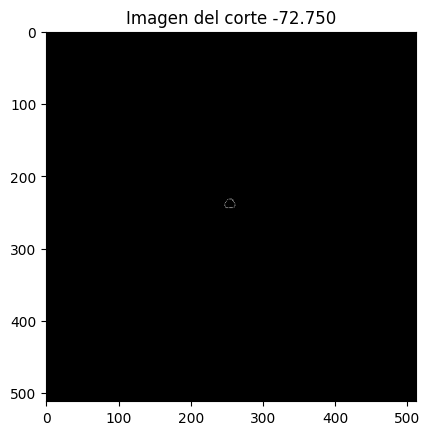

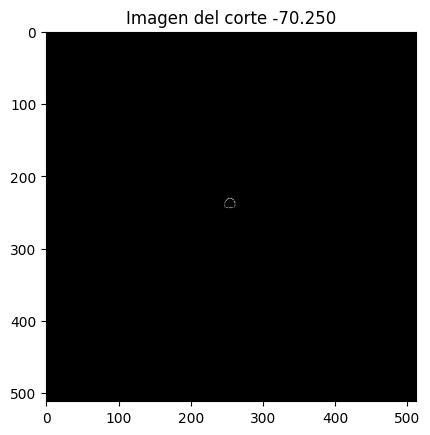

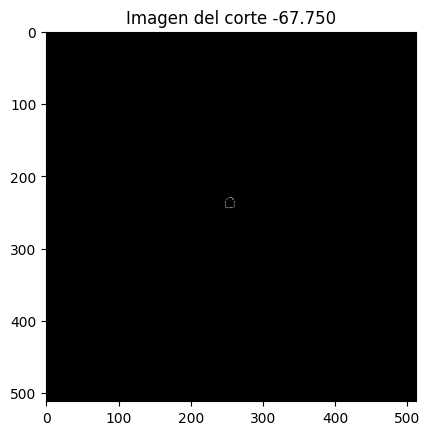

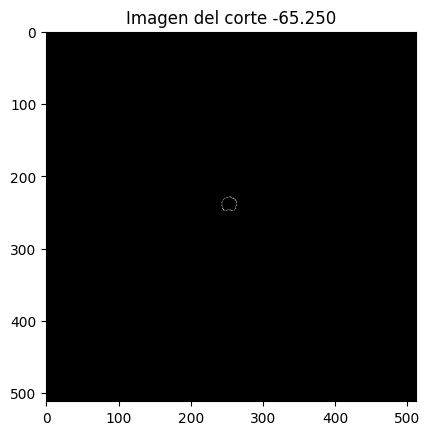

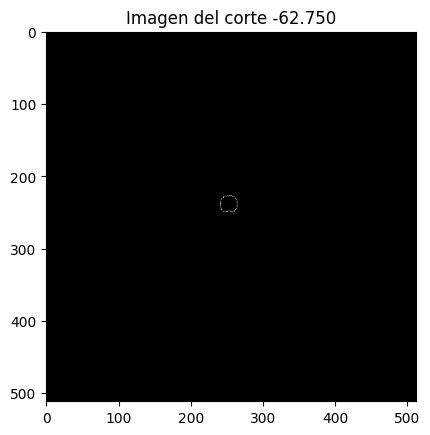

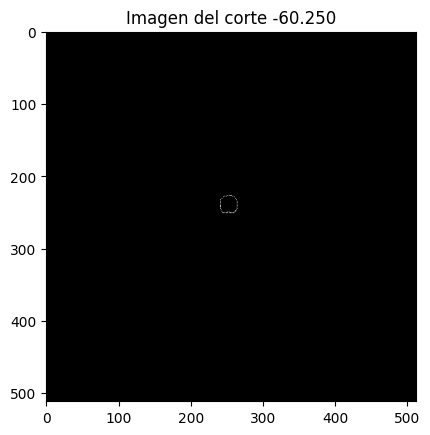

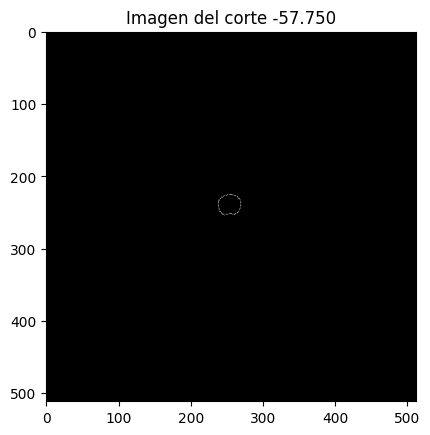

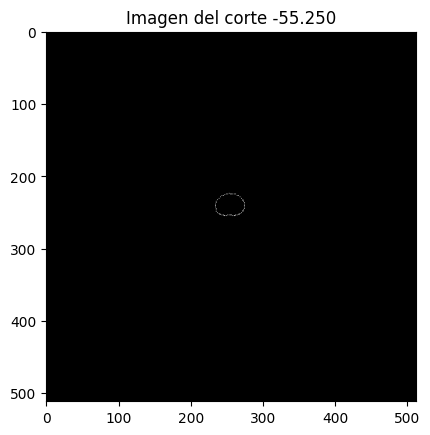

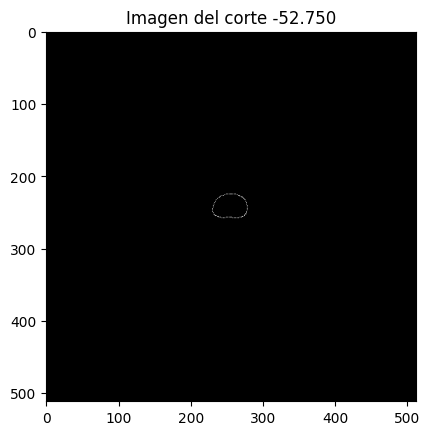

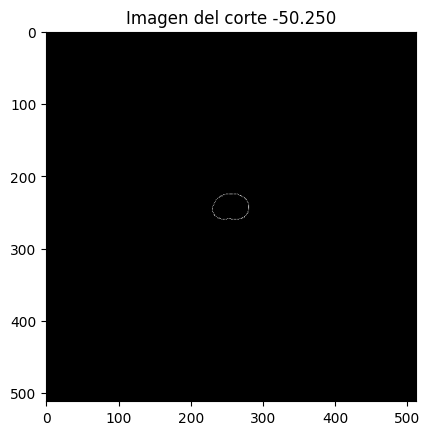

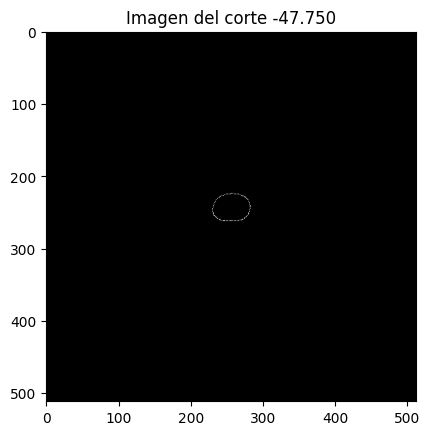

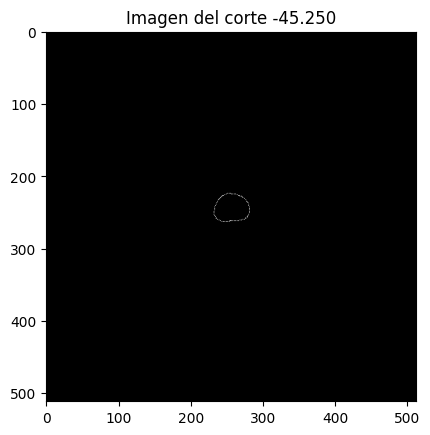

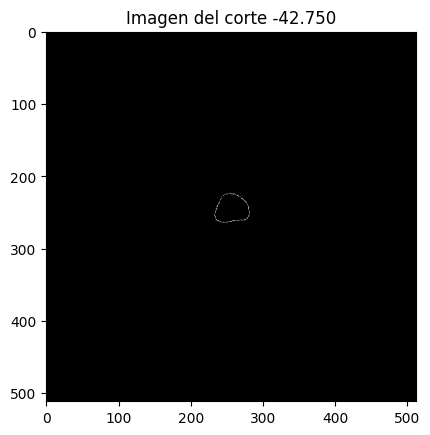

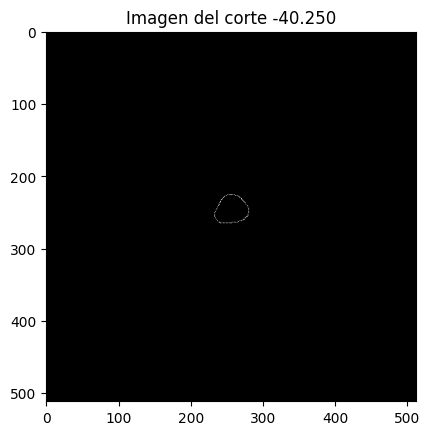

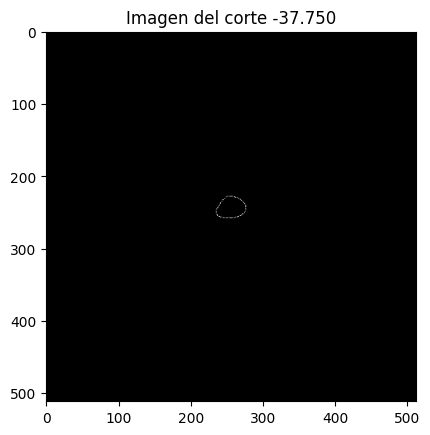

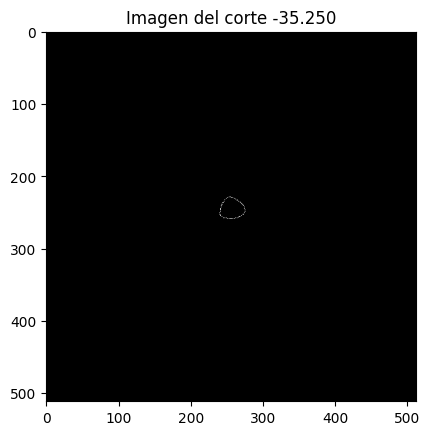

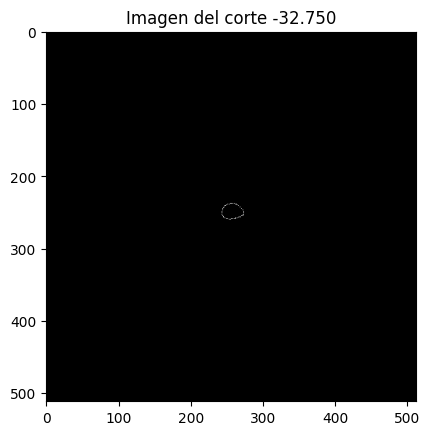

-----------------------------------------------------------------------------------------------------------


In [30]:
# Diccionario para almacenar las imágenes de contornos 
imagenes_cortes = {}
# Ajustar coordenadas al origen y centrar la figura
for corte, coordenadas in PTV_coordenadas_ok.items():
    coordenadas = np.array(coordenadas, dtype=float)
    
    # Centrar la figura (ajustar al centro de la imagen)
    coordenadas[:, :2] += [columnas // 2, filas // 2]

    # Crear una matriz de ceros para la imagen
    imagen = np.zeros((filas, columnas)) 

    # Asignar valor 1 a los puntos en la imagen si están dentro del rango
    for punto in coordenadas:
        y, x, _ = punto.round().astype(int)  # Redondear y convertir a enteros
        if 0 <= x < filas and 0 <= y < columnas:
            imagen[x, y] = 1

    # Almacenar la imagen en el diccionario de imágenes
    imagenes_cortes[corte] = imagen



imagenes_cortes_ordenado = dict(sorted(imagenes_cortes.items(), key=lambda x: x[0], reverse=True))
print("-----------------------------------------------------------------------------------------------------------")
print("Imprimimos los contoros del PTV")
# Mostrar algunas imágenes de ejemplo
for corte, imagen in imagenes_cortes_ordenado.items():
    plt.imshow(imagen, cmap='gray', origin='upper')
    plt.title(f'Imagen del corte {corte}')
    plt.show()

print("-----------------------------------------------------------------------------------------------------------")

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Diccionario para almacenar las imágenes
puntos_contorno = {}

# Iterar sobre los cortes y coordenadas
for corte, coordenadas in PTV_coordenadas_ok.items():
    # Convertir a numpy array
    coordenadas = np.array(coordenadas, dtype=float)

    for punto in coordenadas:
        y, x, _ = punto.round().astype(int)  # Redondear y convertir a enteros
        punto_sin_z = [x,y]

    # Almacenar la imagen en el diccionario de imágenes
    puntos_contorno[corte] = punto_sin_z

print(puntos_contorno)

{'-72.750': [-23, -5], '-70.250': [-25, -4], '-67.750': [-25, -5], '-65.250': [-25, -9], '-62.750': [-29, -5], '-60.250': [-29, -5], '-57.750': [-29, -9], '-55.250': [-31, -7], '-52.750': [-31, -7], '-50.250': [-31, -7], '-47.750': [-31, -7], '-45.250': [-31, -7], '-42.750': [-31, -7], '-40.250': [-29, -7], '-37.750': [-27, -7], '-35.250': [-27, -3], '-32.750': [-17, -5]}


In [ ]:
import numpy as np
import cv2

contornos = []
for z_2 , coordenadas_2 in puntos_contorno.items(): 

    contours = np.array(coordenadas_2, dtype=np.int32)
    # Asegúrate de que el arreglo tenga la forma correcta (n, 1, 2)
    contours = contours.reshape((-1, 1, 2))
    contornos.append(contours)
    
lista_de_contornos = [contornos]

img = np.zeros( (filas, columnas) ) # create a single channel 200x200 pixel black image 
cv2.fillPoly(img, pts =contornos, color=(255,255,255))
cv2.imshow(" ", img)
cv2.waitKey()